- Nama : Fisan Syafa Nayoma
- NIM : 22.11.4836
- Kelas : PDM3

In [ ]:
!pip install huggingface_hub[hf_xet]
import os
import numpy as np
import pandas as pd
import librosa
import zipfile
import cv2
import librosa.display
import warnings
from sklearn.preprocessing import StandardScaler, LabelEncoder
from transformers import BertTokenizer, BertModel
import torch
from google.colab import files
from imblearn.over_sampling import SMOTE
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from torchvision import models
from keras.models import Model
from keras.layers import Input, Dense, Concatenate, Average
from tensorflow.keras.applications import VGG16
import tensorflow as tf
from google.colab import drive
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
import string
import nltk
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Mount Google Drive
drive.mount('/content/drive')

# Path ke file di Google Drive
text_file_path = '/content/drive/MyDrive/ambigu/tweet_emotions_combined.csv'
nrc_vad_file_path = '/content/drive/MyDrive/ambigu/NRC-VAD-Lexicon.txt'
ravdess_zip_path = '/content/drive/MyDrive/ambigu/RAVDESS.zip'
tess_zip_path = '/content/drive/MyDrive/ambigu/Tess.zip'
fer_zip_path = '/content/drive/MyDrive/ambigu/FER-2013.zip'

# Baca file dari Google Drive
print("Membaca file teks dari Google Drive...")
df_text = pd.read_csv(text_file_path)
print("Membaca file NRC-VAD dari Google Drive...")
nrc_vad = pd.read_csv(nrc_vad_file_path, sep="\t", names=['Word', 'Valence', 'Arousal', 'Dominance'], header=None)

# Direktori ekstraksi
extract_path_ravdess = "./ravdess_audio"
os.makedirs(extract_path_ravdess, exist_ok=True)
extract_path_tess = "./Tess"
os.makedirs(extract_path_tess, exist_ok=True)
extract_path_fer = "./FER-2013"
os.makedirs(extract_path_fer, exist_ok=True)

# Ekstrak RAVDESS
print("Ekstrak RAVDESS...")
temp_ravdess = zipfile.ZipFile(ravdess_zip_path, 'r')
temp_ravdess.extractall(extract_path_ravdess)
temp_ravdess.close()
print("RAVDESS berhasil diekstrak.")

# Ekstrak TESS
print("Ekstrak TESS...")
temp_tess = zipfile.ZipFile(tess_zip_path, 'r')
temp_tess.extractall(extract_path_tess)
temp_tess.close()
print("TESS berhasil diekstrak.")

# Ekstrak FER-2013
print("Ekstrak FER-2013...")
temp_fer = zipfile.ZipFile(fer_zip_path, 'r')
temp_fer.extractall(extract_path_fer)
temp_fer.close()
print("FER-2013 berhasil diekstrak.")


Mounted at /content/drive
Membaca file teks dari Google Drive...
Membaca file NRC-VAD dari Google Drive...
Ekstrak RAVDESS...
RAVDESS berhasil diekstrak.
Ekstrak TESS...
TESS berhasil diekstrak.
Ekstrak FER-2013...
FER-2013 berhasil diekstrak.


### Kode dibawah digunakan agar tiap dataset diatur agar dipilih label sentiment yang telah ditentukan sehingga seseragam dan tidak ada masalah di analisis lebih lanjut.

In [ ]:
emotion_mapping = {
    'anger': 'angry', 'angry': 'angry',
    'disgust': 'disgust',
    'fear': 'fear', 'fearful': 'fear',
    'happy': 'happy', 'happiness': 'happy',
    'neutral': 'neutral',
    'sad': 'sad', 'sadness': 'sad',
    'surprise': 'surprised', 'surprised': 'surprised'
}

COMMON_LABELS = ['neutral', 'happy', 'sad', 'surprised', 'angry', 'fear']
label_encoder = LabelEncoder()
label_encoder.fit(COMMON_LABELS)

df_text['sentiment'] = df_text['sentiment'].str.lower().map(emotion_mapping).fillna('neutral')
df_text = df_text[df_text['sentiment'].isin(COMMON_LABELS)]

# **Missing Value & Ekstraksi Fitur tiap Modalitas**

- TIDAK ADA DATA NULL/LABLE NULL/MISSING VALUE
- Pada dataset teks, audio, dan gambar yang dipilih, tidak terdapat missing value sehingga tidak perlu dilakukan proses pengisian atau penghapusan data kosong.

## Teks
Hasil dibawah, menunjukkan bahwa jumlah data yang NULL pada kolom text dan sentiment = 0, yang berarti tidak ada data yang kosong.

In [ ]:
# DATASET TEXT
print("\nJumlah data TEXT yang null di setiap kolom:")
df_text.isnull().sum()


Jumlah data TEXT yang null di setiap kolom:


,0
text,0
sentiment,0


In [ ]:
nltk.download('stopwords')

# Inisialisasi stopwords dan stemming
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

df_preprocessing = df_text[['text']].copy()
df_preprocessing.rename(columns={'text': 'original_text'}, inplace=True)

# Konversi ke huruf kecil
df_preprocessing['lowercase'] = df_preprocessing['original_text'].str.lower()

# Hapus angka
df_preprocessing['remove_numbers'] = df_preprocessing['lowercase'].apply(lambda x: re.sub(r'\d+', '', x))

# Hapus tanda baca
df_preprocessing['remove_punctuation'] = df_preprocessing['remove_numbers'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

# 4. Tokenisasi, hapus stopwords, dan stemming
def tokenize_stem(text):
    words = text.split()
    words = [stemmer.stem(word) for word in words if word not in stop_words]
    return ' '.join(words)

df_preprocessing['remove_stopwords_stem'] = df_preprocessing['remove_punctuation'].apply(tokenize_stem)

print("Tabel Perbandingan Preprocessing:")
print(df_preprocessing.head(10))
df_preprocessing.head(10)

# Ekstraksi Fitur Teks (BERT + NRC-VAD)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased")

# Penggunaan GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model.to(device)

# ekstraksi fitur VAD
def extract_vad_features(text):
    words = text.split()
    valence, arousal, dominance = [], [], []
    for word in words:
        if word in nrc_vad['Word'].values:
            entry = nrc_vad[nrc_vad['Word'] == word].iloc[0]
            valence.append(entry['Valence'])
            arousal.append(entry['Arousal'])
            dominance.append(entry['Dominance'])
    return np.array([
        np.mean(valence) if valence else 0,
        np.mean(arousal) if arousal else 0,
        np.mean(dominance) if dominance else 0
    ])

# ekstraksi fitur BERT
def extract_bert_features(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()

# Ekstraksi fitur
X_text_vad = np.array([extract_vad_features(text) for text in df_text['text']])
X_text_bert = np.array([extract_bert_features(text) for text in df_text['text']])

scaler_bert = StandardScaler()
X_text_bert = scaler_bert.fit_transform(X_text_bert)

# Gabungkan fitur
X_text = np.hstack([X_text_vad, X_text_bert])
y_text = label_encoder.transform(df_text['sentiment'])

# Konversi X_text_vad dan X_text_bert ke DataFrame
df_vad = pd.DataFrame(X_text_vad, columns=['Valence', 'Arousal', 'Dominance'])
df_bert = pd.DataFrame(X_text_bert, columns=[f'BERT_{i}' for i in range(X_text_bert.shape[1])])


df_combined = pd.concat([df_vad, df_bert], axis=1)

print("\nTabel setelah penggabungan fitur NRC-VAD dan BERT:")
print(df_combined.head(10))
df_combined.head(10)

# Tampilkan jumlah data per label
label_counts = df_text['sentiment'].value_counts()
print("\nJumlah data per label:")
print(label_counts)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Tabel Perbandingan Preprocessing:
                                       original_text  \
0  the poetry event was a success. I don't think ...   
1                @MichelleZen That sounds good, too!   
2  its sad that the rats are becoming aggressive ...   
3                               I FOUND A PROM DRESS   
4  got THE best mothers day present from Tys. It ...   
5  i wanted to get good grades too their concern ...   
6            now i'm awake i can't get back to sleep   
7                          @Karen230683 waaa you too   
8  So sick &gt;.&lt; feeling shitty whole body ac...   
9  thinking about new.. oh yes .. btw bankroll st...   

                                           lowercase  \
0  the poetry event was a success. i don't think ...   
1                @michellezen that sounds good, too!   
2  its sad that the rats are becoming aggressive ...   
3                               i found a prom dress   
4  got the best mothers day present from tys. it ...   
5  i wanted t

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]


Tabel setelah penggabungan fitur NRC-VAD dan BERT:
    Valence   Arousal  Dominance    BERT_0    BERT_1    BERT_2    BERT_3  \
0  0.664875  0.416500   0.596375 -1.519009 -0.150525 -1.229215  0.704202   
1  0.000000  0.000000   0.000000  0.137627  0.811491 -0.204385  0.552323   
2  0.407000  0.527750   0.446500  0.564261  1.756237 -1.913765 -0.628087   
3  0.000000  0.000000   0.000000 -0.033311 -2.065822 -1.864708  1.876545   
4  0.575000  0.367000   0.478000 -2.705802 -0.175697 -0.410916  1.248465   
5  0.616286  0.589000   0.605571  0.048202  0.035457 -1.980029  0.119761   
6  0.641000  0.376500   0.520750 -0.038105  0.919714  0.583858 -0.231637   
7  0.000000  0.000000   0.000000  1.206250  1.565084  0.275396 -0.745099   
8  0.516556  0.537333   0.489000 -0.037829 -1.200425  2.268187 -0.414243   
9  0.417714  0.456000   0.392571 -0.037501 -1.023280  1.218723  0.697619   

     BERT_4    BERT_5    BERT_6  ...  BERT_758  BERT_759  BERT_760  BERT_761  \
0  0.302850  0.407896  0.055100

## Audio
Pada dataset audio, Dapat dilihat bahwa pada kolom file_path dan sentiment memiliki nilai 0 yang berarti tidak ada data yang kosong.

In [ ]:
warnings.filterwarnings("ignore", category=UserWarning, module="librosa")

# Mapping Kode Emosi untuk RAVDESS
emotion_code_to_name = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fear',
    '07': 'disgust',
    '08': 'surprised'
}

# Ambil File Audio dan Label dari RAVDESS
ravdess_audio_files = []
ravdess_labels = []

for root, _, files in os.walk(extract_path_ravdess):
    for file in files:
        if file.endswith('.wav'):
            filepath = os.path.join(root, file)
            filename = os.path.basename(file)
            parts = filename.split('-')
            emotion_code = parts[2]
            emotion_name = emotion_code_to_name.get(emotion_code, 'neutral')

            # Filter label emosi
            if emotion_name in ['happy', 'neutral', 'sad', 'surprised', 'angry', 'fear']:
                ravdess_audio_files.append(filepath)
                ravdess_labels.append(emotion_name)

# Ambil File Audio dan Label dari TESS
tess_audio_files = []
tess_labels = []

for root, dirs, files in os.walk(extract_path_tess):
    for file in files:
        if file.endswith('.wav'):
            filepath = os.path.join(root, file)
            folder_name = os.path.basename(root)

            # Ekstrak label dari folder
            if "_" in folder_name:
                emotion_name = folder_name.split("_")[-1]
                if emotion_name == "pleasant_surprise":
                    emotion_name = "surprised"

                # Filter label
                if emotion_name in ['happy', 'neutral', 'sad', 'surprised', 'angry', 'fear']:
                    tess_audio_files.append(filepath)
                    tess_labels.append(emotion_name)

# Gabungan Dataset RAVDESS & TESS
audio_files = np.array(ravdess_audio_files + tess_audio_files)
y_audio = np.array(ravdess_labels + tess_labels)

y_audio = label_encoder.transform(y_audio)

# Informasi jumlah data per label audio
label_counts_audio = pd.Series(y_audio).value_counts()
print("\nJumlah data per label (audio):")
print(label_counts_audio)

# Konversi untuk pengecekan missing value
df_audio_cek = pd.DataFrame({"file_path": audio_files, "sentiment": y_audio})


# Pengecekan Missing Value
print("\nJumlah data AUDIO yang null di setiap kolom:")
print(df_audio_cek.isnull().sum())

# Ekstraksi Fitur Audio
def extract_audio_features(file_path, max_pad_len=150):
    y, sr = librosa.load(file_path, sr=22050)

    # Ekstraksi MFCC dengan padding
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    delta_mfcc = librosa.feature.delta(mfcc)
    delta2_mfcc = librosa.feature.delta(mfcc, order=2)

    # Padding agar semua fitur punya panjang yang sama
    def pad_features(feature, max_len=max_pad_len):
        if feature.shape[1] < max_len:
            return np.pad(feature, ((0, 0), (0, max_len - feature.shape[1])), mode='constant')
        else:
            return feature[:, :max_len]

    mfcc = pad_features(mfcc)
    delta_mfcc = pad_features(delta_mfcc)
    delta2_mfcc = pad_features(delta2_mfcc)

    return np.hstack([
        np.mean(mfcc, axis=1),
        np.mean(delta_mfcc, axis=1),
        np.mean(delta2_mfcc, axis=1)
    ])

# Ekstraksi Fitur dari Semua File Audio
X_audio = np.array([extract_audio_features(file) for file in audio_files])

# Normalisasi Fitur
scaler_audio = StandardScaler()
X_audio = scaler_audio.fit_transform(X_audio)

# Konversi ke DataFrame
feature_columns = (
    [f'MFCC_{i}' for i in range(13)] +
    [f'Delta_MFCC_{i}' for i in range(13)] +
    [f'Delta2_MFCC_{i}' for i in range(13)]
)

df_audio = pd.DataFrame(X_audio, columns=feature_columns)
df_audio['sentiment'] = label_encoder.inverse_transform(y_audio)

# Tampilan Hasil Ekstraksi Fitur Audio
print("\nTabel Hasil Ekstraksi Fitur Audio:")
print(df_audio.head(10))
df_audio.head(10)


Jumlah data per label (audio):
0    592
2    592
3    496
1    392
4    392
5    392
Name: count, dtype: int64

Jumlah data AUDIO yang null di setiap kolom:
file_path    0
sentiment    0
dtype: int64

Tabel Hasil Ekstraksi Fitur Audio:
     MFCC_0    MFCC_1    MFCC_2    MFCC_3    MFCC_4    MFCC_5    MFCC_6  \
0 -1.215228  1.217622 -0.054620  0.270244  2.188053  2.241627  1.774123   
1 -0.695578  0.820080 -0.934183 -0.153835 -1.177431 -0.873177  2.519236   
2 -2.609590  1.696299  1.976886  2.044244  2.468826  2.707449  1.624916   
3 -1.224711  2.164827 -0.505538  0.797200  1.330777 -0.312279 -0.265031   
4 -0.564330  0.135033 -2.158998 -0.380790 -2.038814 -0.944451  0.951991   
5 -1.419285  0.562105  0.082450 -0.032177  0.481282  0.346945 -0.657266   
6 -2.137696  1.839685  1.602955  1.292621  1.593297  2.544893  2.310235   
7 -0.698665  1.202066  0.606569  0.027088  0.372004  0.411569  0.621870   
8 -1.060030 -0.209543 -1.083296 -0.848404 -2.035967 -1.764112 -0.804713   
9 -0.068497  

,MFCC_0,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,...,Delta2_MFCC_4,Delta2_MFCC_5,Delta2_MFCC_6,Delta2_MFCC_7,Delta2_MFCC_8,Delta2_MFCC_9,Delta2_MFCC_10,Delta2_MFCC_11,Delta2_MFCC_12,sentiment
0,-1.215228,1.217622,-0.054620,0.270244,2.188053,2.241627,1.774123,-0.161207,-0.455970,1.921267,...,-0.092096,-0.153235,0.689880,1.187442,0.877734,0.058337,-0.126545,0.232973,-0.180010,fear
1,-0.695578,0.820080,-0.934183,-0.153835,-1.177431,-0.873177,2.519236,-0.475278,-0.218255,-0.632756,...,-0.853314,-0.552265,-0.201761,-0.512776,-0.736069,-0.156086,0.307220,0.348950,0.101930,angry
2,-2.609590,1.696299,1.976886,2.044244,2.468826,2.707449,1.624916,0.422430,1.275715,2.320837,...,-0.244175,-0.145318,-0.577892,-0.638019,-0.354592,0.274416,-0.155827,-0.709884,0.204351,sad
3,-1.224711,2.164827,-0.505538,0.797200,1.330777,-0.312279,-0.265031,-0.585528,-1.072068,0.326786,...,-0.217388,-0.243736,-0.034508,-0.238450,-0.435073,-0.093679,-0.050727,-0.011096,-0.160874,happy
4,-0.564330,0.135033,-2.158998,-0.380790,-2.038814,-0.944451,0.951991,-1.396709,0.153996,-1.069667,...,-0.240739,-0.278027,-0.066326,-0.269789,-0.468025,-0.125569,-0.080798,-0.043717,-0.190906,angry
5,-1.419285,0.562105,0.082450,-0.032177,0.481282,0.346945,-0.657266,0.886515,0.075855,-0.132705,...,-0.279241,-0.333497,-0.116283,-0.316838,-0.514135,-0.165338,-0.111813,-0.068280,-0.203762,surprised
6,-2.137696,1.839685,1.602955,1.292621,1.593297,2.544893,2.310235,1.154161,1.014578,0.735393,...,-0.768771,-0.769854,-0.226626,-0.541227,-1.039600,-0.867943,-0.672253,-0.594475,-0.501919,sad
7,-0.698665,1.202066,0.606569,0.027088,0.372004,0.411569,0.621870,1.331630,-0.537741,-1.188588,...,-0.295986,-0.382268,-0.189096,-0.418657,-0.646741,-0.303266,-0.236422,-0.191608,-0.308913,happy
8,-1.060030,-0.209543,-1.083296,-0.848404,-2.035967,-1.764112,-0.804713,-1.877300,-0.660096,-1.488518,...,-0.230935,-0.262876,-0.051384,-0.253990,-0.450086,-0.106865,-0.062028,-0.022457,-0.170905,angry
9,-0.068497,1.687262,-0.743933,0.711571,1.262984,0.863317,-0.321539,0.840983,-0.287438,-1.752386,...,-0.703745,-0.046054,-0.388374,0.035937,-0.176286,-0.454906,-0.541297,0.571055,-0.974351,fear


## Gambar
pada dataset gambar, pada kolom file_path dan sentiment memiliki nilai 0 yang menunjukkan bahwa tidak ada data yang kosong.

In [ ]:
# Load model VGG16 tanpa top
vgg16 = VGG16(weights='imagenet', include_top=False, pooling='avg')

# Fungsi untuk memuat dan memproses gambar
def load_and_preprocess_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224]) / 255.0
    return img

# Fungsi untuk ekstraksi fitur menggunakan VGG16
def extract_image_features_batch(image_batch):
    return vgg16(image_batch, training=False)

# Ambil path gambar dan labelnya
image_paths = []
y_image = []

for subset in ['train', 'test']:
    subset_path = os.path.join(extract_path_fer, subset)
    for emotion in os.listdir(subset_path):
        emotion_path = os.path.join(subset_path, emotion)
        if not os.path.isdir(emotion_path):
            continue
        standardized_label = emotion_mapping.get(emotion.lower(), 'neutral')
        for file in os.listdir(emotion_path):
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(emotion_path, file))
                y_image.append(standardized_label)

# Gabungan Dataset
df_image_cek = pd.DataFrame({"file_path": image_paths, "sentiment": y_image})

# Pengecekan Missing Value
print("\nJumlah data GAMBAR yang null di setiap kolom:")
print(df_image_cek.isnull().sum())

label_counts_image = pd.Series(y_image).value_counts()
print("\nJumlah data per label (gambar):")
print(label_counts_image)

# Konversi label
y_image = np.array(y_image)
mask = np.isin(y_image, COMMON_LABELS)
image_paths = np.array(image_paths)[mask]
y_image = y_image[mask]
y_image = label_encoder.transform(y_image)

# proses batch
image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
image_dataset = image_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
image_dataset = image_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Ekstraksi fitur
X_image = vgg16.predict(image_dataset)

# Normalisasi fitur
scaler_image = StandardScaler()
X_image = scaler_image.fit_transform(X_image)

print("Ekstraksi fitur selesai! Shape X_image:", X_image.shape)

# Konversi ke DataFrame
df_image = pd.DataFrame(X_image)

# Menambahkan kolom label emosi dengan nama "sentiment"
df_image['sentiment'] = label_encoder.inverse_transform(y_image)

# Menampilkan tabel hasil ekstraksi fitur gambar
print("\nTabel Hasil Ekstraksi Fitur Gambar:")
print(df_image.head(10))
df_image.head(10)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Jumlah data GAMBAR yang null di setiap kolom:
file_path    0
sentiment    0
dtype: int64

Jumlah data per label (gambar):
happy        8989
neutral      6198
sad          6077
fear         5121
angry        4953
surprised    4002
disgust       547
Name: count, dtype: int64
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 231s 197ms/step
Ekstraksi fitur selesai! Shape X_image: (35340, 512)

Tabel Hasil Ekstraksi Fitur Gambar:
          0        1         2         3         4         5         6  \
0  2.071813 -0.10832 -1.120106  2.583167 -1.696942 -0.204871  1.122290   
1  1.494752 -0.10832  1.576556 -1.277201 -0.679338 -0.204871  0.973494   
2  1.586409 -0.10832  1.564180  0.365520 -1.017125 -0.204871  1.901932   
3 -0.395921 -0.10832  0.038432 -1.104261  2.366591 -0.204871 -0.609055   
4 -1.401430 -0.10832 -1.930498 -0.755782  2.036031 -0.204871 -0.609055   
5 -1.055249 -0.10832 -1.533983  2.914770 -1.536376 -0.204871 -0.084953   
6 -0.916568 -0.1083

,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,sentiment
0,2.071813,-0.10832,-1.120106,2.583167,-1.696942,-0.204871,1.122290,1.389949,-1.174121,9.718803,...,-0.162230,-1.095951,-0.537282,-0.610593,-0.887208,-0.351618,-0.076009,-1.042416,-0.308691,fear
1,1.494752,-0.10832,1.576556,-1.277201,-0.679338,-0.204871,0.973494,2.508445,1.526137,-0.621992,...,0.256196,0.432234,0.049394,1.599886,0.266487,4.107665,-0.221942,-1.417364,-0.308691,fear
2,1.586409,-0.10832,1.564180,0.365520,-1.017125,-0.204871,1.901932,0.351631,0.229723,-0.470693,...,2.456240,0.079157,-0.209142,0.821446,-1.162918,-0.409322,1.493323,0.055892,-0.308691,fear
3,-0.395921,-0.10832,0.038432,-1.104261,2.366591,-0.204871,-0.609055,-0.249539,-0.654212,-0.717046,...,-0.611221,0.160797,-0.667628,-0.480025,0.879550,-0.409322,-0.909876,-0.251425,-0.308691,fear
4,-1.401430,-0.10832,-1.930498,-0.755782,2.036031,-0.204871,-0.609055,-0.899678,0.094421,-0.717046,...,-1.947271,-0.680311,-0.239545,-1.198641,2.531481,-0.409322,-1.038569,0.259079,-0.308691,fear
5,-1.055249,-0.10832,-1.533983,2.914770,-1.536376,-0.204871,-0.084953,-0.684838,-1.507217,3.553928,...,-0.866896,-1.757022,-0.604330,2.689875,-0.249369,-0.262544,0.730918,0.568663,0.404192,fear
6,-0.916568,-0.10832,1.613953,-0.613067,1.568042,-0.204871,-0.018110,-0.479063,-0.830273,-0.398372,...,-0.055389,-0.268825,0.283163,1.924359,0.490362,-0.409322,-0.801755,0.130253,-0.308691,fear
7,-0.626195,-0.10832,-0.888191,0.342502,0.133155,-0.204871,-0.574498,1.353140,2.651352,-0.041698,...,2.017529,-0.870115,-0.409754,-0.904827,-0.667244,-0.409322,-0.511685,0.253891,-0.308691,fear
8,0.126767,-0.10832,-0.910437,-1.022380,-1.056616,-0.204871,-0.572386,0.297280,-0.004701,0.017777,...,-0.748431,0.939408,0.863167,0.307962,-0.818824,-0.354844,-0.331909,-0.298625,-0.308691,fear
9,-0.558595,-0.10832,1.740310,0.746935,-0.246785,-0.204871,-0.277689,-0.150922,0.001593,-0.678658,...,-0.563816,0.142945,-0.775482,2.710720,-0.628173,-0.409322,0.293877,0.270998,1.281007,fear


# **FITUR SELECTION**

Menggunakan Mutual Information untuk menentukan fitur terbaik dan memilihnya 100 dari 771 fitur di **teks** dan 513 fitur di **gambar**

## **Teks**

Dari 771 fitur, terpilih 100 fitur terbaik yaitu :

['Valence', 'Arousal', 'Dominance', 'BERT_0', 'BERT_2', 'BERT_6', 'BERT_10', 'BERT_16', 'BERT_20', 'BERT_22', 'BERT_39', 'BERT_42', 'BERT_47', 'BERT_67', 'BERT_68', 'BERT_74', 'BERT_83', 'BERT_94', 'BERT_96', 'BERT_104', 'BERT_110', 'BERT_112', 'BERT_122', 'BERT_124', 'BERT_144', 'BERT_156', 'BERT_176', 'BERT_177', 'BERT_186', 'BERT_198', 'BERT_200', 'BERT_204', 'BERT_217', 'BERT_223', 'BERT_225', 'BERT_226', 'BERT_235', 'BERT_236', 'BERT_243', 'BERT_262', 'BERT_298', 'BERT_311', 'BERT_319', 'BERT_327', 'BERT_344', 'BERT_348', 'BERT_350', 'BERT_353', 'BERT_358', 'BERT_364', 'BERT_368', 'BERT_370', 'BERT_376', 'BERT_378', 'BERT_387', 'BERT_395', 'BERT_398', 'BERT_410', 'BERT_420', 'BERT_421', 'BERT_424', 'BERT_428', 'BERT_438', 'BERT_449', 'BERT_452', 'BERT_463', 'BERT_476', 'BERT_479', 'BERT_481', 'BERT_483', 'BERT_485', 'BERT_508', 'BERT_516', 'BERT_518', 'BERT_519', 'BERT_527', 'BERT_568', 'BERT_575', 'BERT_589', 'BERT_590', 'BERT_597', 'BERT_626', 'BERT_631', 'BERT_649', 'BERT_652', 'BERT_664', 'BERT_688', 'BERT_700', 'BERT_708', 'BERT_709', 'BERT_712', 'BERT_713', 'BERT_716', 'BERT_717', 'BERT_726', 'BERT_733', 'BERT_738', 'BERT_744', 'BERT_755', 'BERT_760']

In [ ]:
k = 100

# Seleksi fitur dengan Mutual Information
selector = SelectKBest(score_func=mutual_info_classif, k=k)
X_text = selector.fit_transform(df_combined, y_text)

selected_mask = selector.get_support()
selected_features = df_combined.columns[selected_mask]

df_combined = df_combined[selected_features]

print(f"\n{len(selected_features)} fitur terbaik yang dipilih berdasarkan Mutual Information:")
print(selected_features.tolist())
print(df_combined.head())



100 fitur terbaik yang dipilih berdasarkan Mutual Information:
['Valence', 'Arousal', 'Dominance', 'BERT_0', 'BERT_2', 'BERT_6', 'BERT_10', 'BERT_16', 'BERT_20', 'BERT_22', 'BERT_39', 'BERT_42', 'BERT_47', 'BERT_67', 'BERT_68', 'BERT_74', 'BERT_83', 'BERT_94', 'BERT_96', 'BERT_104', 'BERT_110', 'BERT_112', 'BERT_122', 'BERT_124', 'BERT_144', 'BERT_156', 'BERT_176', 'BERT_177', 'BERT_186', 'BERT_198', 'BERT_200', 'BERT_204', 'BERT_217', 'BERT_223', 'BERT_225', 'BERT_226', 'BERT_235', 'BERT_236', 'BERT_243', 'BERT_262', 'BERT_298', 'BERT_311', 'BERT_319', 'BERT_327', 'BERT_344', 'BERT_348', 'BERT_350', 'BERT_353', 'BERT_358', 'BERT_364', 'BERT_368', 'BERT_370', 'BERT_376', 'BERT_378', 'BERT_387', 'BERT_395', 'BERT_398', 'BERT_410', 'BERT_420', 'BERT_421', 'BERT_424', 'BERT_428', 'BERT_438', 'BERT_449', 'BERT_452', 'BERT_463', 'BERT_476', 'BERT_479', 'BERT_481', 'BERT_485', 'BERT_486', 'BERT_508', 'BERT_516', 'BERT_518', 'BERT_519', 'BERT_527', 'BERT_568', 'BERT_575', 'BERT_589', 'BERT_5

## **Gambar**

Dari 513 fitur, terpilih 100 fitur terbaik yaitu :

[0, 8, 15, 27, 29, 30, 33, 34, 46, 57, 58, 60, 67, 71, 86, 88, 94, 97, 99, 100, 123, 124, 133, 137, 143, 149, 155, 157, 159, 165, 166, 174, 179, 183, 193, 194, 198, 199, 214, 218, 226, 229, 237, 238, 240, 243, 247, 249, 250, 254, 257, 265, 269, 270, 274, 282, 289, 291, 297, 298, 307, 321, 329, 335, 338, 341, 343, 350, 359, 365, 375, 377, 380, 381, 392, 397, 406, 409, 411, 413, 414, 417, 420, 432, 433, 439, 445, 450, 451, 454, 463, 466, 469, 471, 474, 476, 482, 496, 499, 506]

In [ ]:
X_image = df_image.drop(columns=['sentiment'])
y_image = label_encoder.transform(df_image['sentiment'])

# Seleksi fitur terbaik
k = 100
selector_img = SelectKBest(score_func=mutual_info_classif, k=k)
X_image = selector_img.fit_transform(X_image, y_image)

selected_mask_img = selector_img.get_support()
selected_columns_img = df_image.drop(columns=['sentiment']).columns[selected_mask_img]

df_image = pd.DataFrame(X_image, columns=selected_columns_img)
df_image['sentiment'] = label_encoder.inverse_transform(y_image)

print(f"\n{len(selected_columns_img)} fitur gambar terbaik yang dipilih berdasarkan Mutual Information:")
print(selected_columns_img.tolist())
print(df_image.head())



100 fitur gambar terbaik yang dipilih berdasarkan Mutual Information:
[8, 15, 27, 29, 30, 33, 34, 46, 57, 58, 60, 67, 71, 86, 88, 94, 97, 98, 99, 100, 123, 124, 133, 137, 143, 149, 155, 157, 159, 165, 166, 174, 179, 183, 193, 194, 198, 199, 214, 218, 226, 229, 237, 238, 241, 243, 247, 249, 250, 254, 257, 265, 269, 270, 274, 282, 289, 291, 297, 298, 307, 321, 329, 335, 338, 341, 343, 350, 359, 365, 375, 377, 380, 381, 392, 397, 406, 409, 411, 413, 414, 417, 420, 432, 433, 439, 445, 447, 450, 451, 454, 463, 466, 469, 471, 474, 476, 482, 496, 499]
          8        15        27        29        30        33        34  \
0 -1.174121 -1.280775  0.690221 -0.222567 -0.837571  0.123706  1.207501   
1  1.526137 -1.250282  0.192299 -0.504712 -0.589808  0.889917 -0.965710   
2  0.229723 -1.469604  0.945501 -0.504712  0.132492  0.750293  0.898721   
3 -0.654212  1.353594 -0.085038 -0.504712  2.629449 -1.092356 -0.102719   
4  0.094421 -0.165589  1.630262 -0.504712 -0.118478 -0.946572 -1.269868  

In [ ]:
print(df_text['sentiment'].value_counts())

sentiment
neutral      27329
happy         5209
sad           5165
surprised     2187
angry         2110
fear          2000
Name: count, dtype: int64


In [ ]:
print(df_audio['sentiment'].value_counts())

sentiment
angry        592
happy        592
neutral      496
fear         392
sad          392
surprised    392
Name: count, dtype: int64


In [ ]:
print(df_image['sentiment'].value_counts())

sentiment
happy        8989
neutral      6198
sad          6077
fear         5121
angry        4953
surprised    4002
Name: count, dtype: int64


# **CLASS IMBALANCE**

Balancing class dilakukan setelah sampel setiap modalitas disamakan, maka kemudian melakukan balancing class menggunakan SMOTE. Dataset perlu diseimbangkan karena jumlah data tiap kelasnya tidak seimbang. visualisasi data before dan after SMOTE ada di paling bawah.

In [ ]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

# Ambil label asli
y_text_labels = label_encoder.inverse_transform(y_text)
y_audio_labels = label_encoder.inverse_transform(y_audio)
y_image_labels = label_encoder.inverse_transform(y_image)

# Target jumlah sampel per label
TARGET_COUNTS = {
    'angry': 592,
    'happy': 592,
    'neutral': 496,
    'sad': 392,
    'fear': 392,
    'surprised': 392
}

# Fungsi untuk memilih sampel sesuai target
def select_fixed_samples(labels, target_counts, seed=42):
    np.random.seed(seed)
    selected_indices = []
    for label, target_count in target_counts.items():
        indices = np.where(labels == label)[0]
        if len(indices) < target_count:
            print(f"Warning: Not enough samples for {label}. Requested {target_count}, available {len(indices)}")
            continue
        selected = np.random.choice(indices, target_count, replace=False)
        selected_indices.extend(selected)
    return np.array(selected_indices)

# Pilih indeks untuk masing-masing modalitas
selected_idx_text = select_fixed_samples(y_text_labels, TARGET_COUNTS)
selected_idx_audio = select_fixed_samples(y_audio_labels, TARGET_COUNTS)
selected_idx_image = select_fixed_samples(y_image_labels, TARGET_COUNTS)

# Verifikasi jumlah sampel per label
def verify_counts(labels, indices, modality_name):
    print(f"\nVerifikasi {modality_name}:")
    selected_labels = labels[indices]
    for label, target in TARGET_COUNTS.items():
        count = np.sum(selected_labels == label)
        print(f"{label}: {count} samples (target: {target})")

verify_counts(y_text_labels, selected_idx_text, "Text")
verify_counts(y_audio_labels, selected_idx_audio, "Audio")
verify_counts(y_image_labels, selected_idx_image, "Image")

# Susun ulang data
X_text = X_text[selected_idx_text]
X_audio = X_audio[selected_idx_audio]
X_image = X_image[selected_idx_image]
y = y_text[selected_idx_text]

# Reshape jika diperlukan
X_text = X_text.reshape((X_text.shape[0], -1))
X_audio = X_audio.reshape((X_audio.shape[0], -1))
X_image = X_image.reshape((X_image.shape[0], -1))

print(f"\nTotal sampel akhir: {X_text.shape[0]}")


Verifikasi Text:
angry: 592 samples (target: 592)
happy: 592 samples (target: 592)
neutral: 496 samples (target: 496)
sad: 392 samples (target: 392)
fear: 392 samples (target: 392)
surprised: 392 samples (target: 392)

Verifikasi Audio:
angry: 592 samples (target: 592)
happy: 592 samples (target: 592)
neutral: 496 samples (target: 496)
sad: 392 samples (target: 392)
fear: 392 samples (target: 392)
surprised: 392 samples (target: 392)

Verifikasi Image:
angry: 592 samples (target: 592)
happy: 592 samples (target: 592)
neutral: 496 samples (target: 496)
sad: 392 samples (target: 392)
fear: 392 samples (target: 392)
surprised: 392 samples (target: 392)

Total sampel akhir: 2856


In [ ]:
print("\nDistribusi Label Setelah Filter (sebelum SMOTE):")
print(Counter(y_text_labels[selected_idx_text]))


Distribusi Label Setelah Filter (sebelum SMOTE):
Counter({np.str_('angry'): 592, np.str_('happy'): 592, np.str_('neutral'): 496, np.str_('sad'): 392, np.str_('fear'): 392, np.str_('surprised'): 392})


In [ ]:
# SMOTE untuk tiap modalitas
smote = SMOTE(random_state=42)
X_text_resampled, y_resampled = smote.fit_resample(X_text, y)
X_audio_resampled, _ = smote.fit_resample(X_audio, y)
X_image_resampled, _ = smote.fit_resample(X_image, y)

print(f"Total samples teks setelah SMOTE: {len(X_text_resampled)}")
print(f"Total samples audio setelah SMOTE: {len(X_audio_resampled)}")
print(f"Total samples image setelah SMOTE: {len(X_image_resampled)}")

total_samples = (
    len(X_text_resampled) + len(X_audio_resampled) + len(X_image_resampled)
)

print(f"Total semua sampel setelah SMOTE: {total_samples}")

Total samples teks setelah SMOTE: 3552
Total samples audio setelah SMOTE: 3552
Total samples image setelah SMOTE: 3552
Total semua sampel setelah SMOTE: 10656


Tampilan data setelah SMOTE untuk memastikan data sudah benar-benar seimbang.

Gambar disimpan ke: /content/label_distribution_SMOTE.png


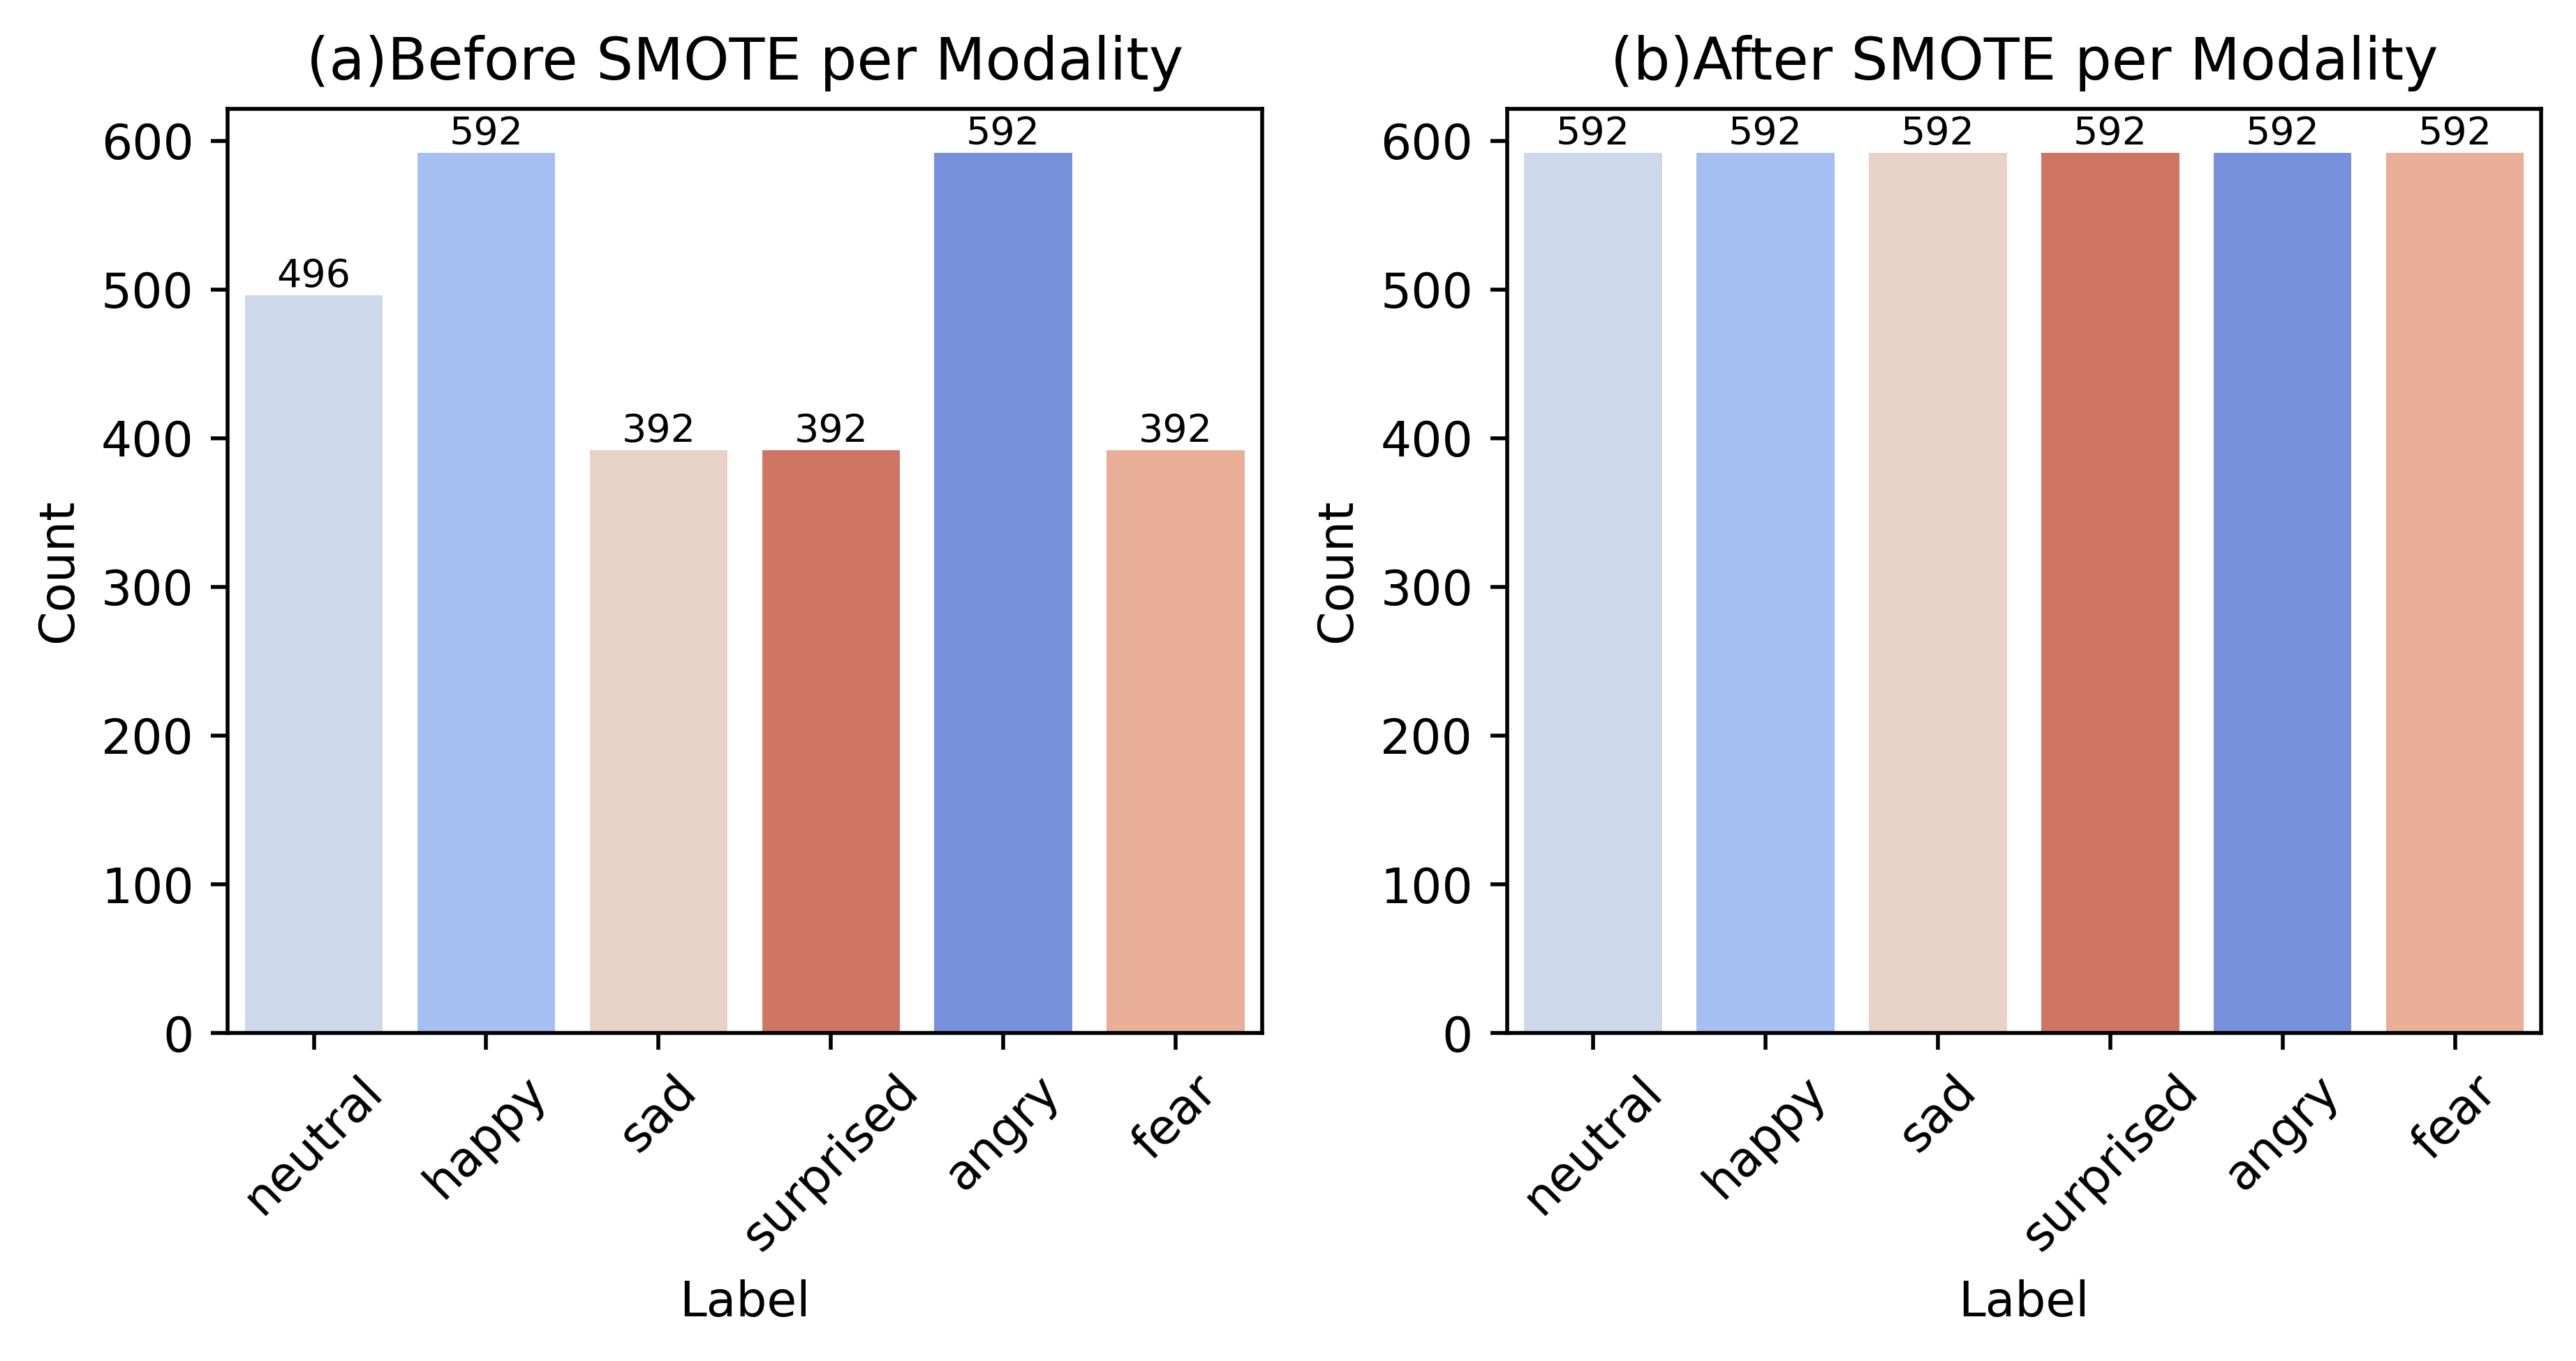

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def plot_label_distribution(y_before, y_after,
                            title_before="(a)Before SMOTE per Modality",
                            title_after="(b)After SMOTE per Modality",
                            save_filename="label_distribution_SMOTE.png"):
    import matplotlib.pyplot as plt
    import seaborn as sns
    from google.colab import files

    # Konversi numeric → nama label
    labels_before = label_encoder.inverse_transform(y_before)
    labels_after  = label_encoder.inverse_transform(y_after)

    # Ukuran dalam inch agar lebar total = 3740 px dengan dpi=500
    width_inch = 7.48
    height_inch = 4
    dpi_val = 500

    fig, axes = plt.subplots(1, 2, figsize=(width_inch, height_inch), dpi=dpi_val)

    # Plot sebelum SMOTE
    ax = axes[0]
    sns.countplot(x=labels_before, hue=labels_before, order=COMMON_LABELS, ax=ax,
                  palette="coolwarm", legend=False)
    ax.set_title(title_before)
    ax.set_xlabel("Label")
    ax.set_ylabel("Count")
    ax.tick_params(axis='x', labelrotation=45)  # Rotasi label X
    for p in ax.patches:
        count = int(p.get_height())
        ax.annotate(f"{count}",
                    (p.get_x() + p.get_width() / 2, p.get_height()),
                    ha='center', va='bottom', fontsize=8)

    # Plot setelah SMOTE
    ax = axes[1]
    sns.countplot(x=labels_after, hue=labels_after, order=COMMON_LABELS, ax=ax,
                  palette="coolwarm", legend=False)
    ax.set_title(title_after)
    ax.set_xlabel("Label")
    ax.set_ylabel("Count")
    ax.tick_params(axis='x', labelrotation=45)  # Rotasi label X
    for p in ax.patches:
        count = int(p.get_height())
        ax.annotate(f"{count}",
                    (p.get_x() + p.get_width() / 2, p.get_height()),
                    ha='center', va='bottom', fontsize=8)

    plt.tight_layout()

    # Simpan dan tawarkan unduhan
    save_path = f"/content/{save_filename}"
    plt.savefig(save_path, dpi=dpi_val, bbox_inches='tight')
    print(f"Gambar disimpan ke: {save_path}")

    plt.show()

    # Unduh otomatis di Colab
    files.download(save_path)

# Contoh pemanggilan
plot_label_distribution(y, y_resampled)


# **PENGGABUNGAN DAN PEMODELAN ARSITEKTUR TRANSFORMER-BASED FUSION**

**Transformer-Based Fusion** bukan hanya metode penggabungan (fusion) fitur multimodal seperti teks, audio, dan gambar. Tetapi juga terlibat secara langsung dalam proses **pemodelan** melalui mekanisme self-attention dan feed-forward network.

Arsitektur ini terdiri dari beberapa komponen penting yang menjadikannya bagian integral dari model pembelajaran:

- Proyeksi Fitur (Feature Projection): Lapisan Dense memproyeksikan setiap fitur modalitas yang berbeda ke dalam dimensi laten yang seragam. Hal tersebut adalah bagian pertama dari proses pembelajaran representasi.

- Stacking & Fusion: Fitur masing-masing modalitas digabungkan ke dalam sebuah tensor multimodal, yang siap untuk diolah oleh lapisan atensi daripada hanya sebagai concatenation statis.

- Multi-Head Attention: **Pada tahap inilah dasar pemodelan**. Lapisan ini memungkinkan model untuk mempelajari hubungan antar-modalitas dan internal.  Fokus tidak hanya menggabungkan, tetapi juga mengevaluasi kontribusi relatif setiap fitur dan meningkatkan representasi yang penting untuk tugas **klasifikasi**.

- Feed Forward Network (FFN): Lapisan FFN memproses representasi yang dihasilkan setelah penghitungan attention. Ini berfungsi sebagai bagian dari jaringan neural untuk mengekstraksi pola yang lebih dalam.

- Pooling dan Output Layer: Lapisan akhir softmax menghubungkan hasil attention dan FFN ke kelas target.

# **LATE FUSION**


==================== FOLD 1/10 ====================

--- Training model: 1. Text-Only ---
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
  > Fold 1 Result for 1. Text-Only: Accuracy = 0.6404, F1-Score = 0.6377

--- Training model: 2. Text + Audio (Late Fusion) ---
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
  > Fold 1 Result for 2. Text + Audio (Late Fusion): Accuracy = 0.7865, F1-Score = 0.7798

--- Training model: 3. Text + Audio + Image (Late Fusion) ---
Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5910 - loss: 1.0778
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9043 - loss: 0.2797
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9588 - loss: 0.1421
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9795 - loss: 0.0777
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9955 - loss: 0.0316
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9972 - loss: 0.0174
Epoch 7/15
100/100 ━━━━━━━━━━━━

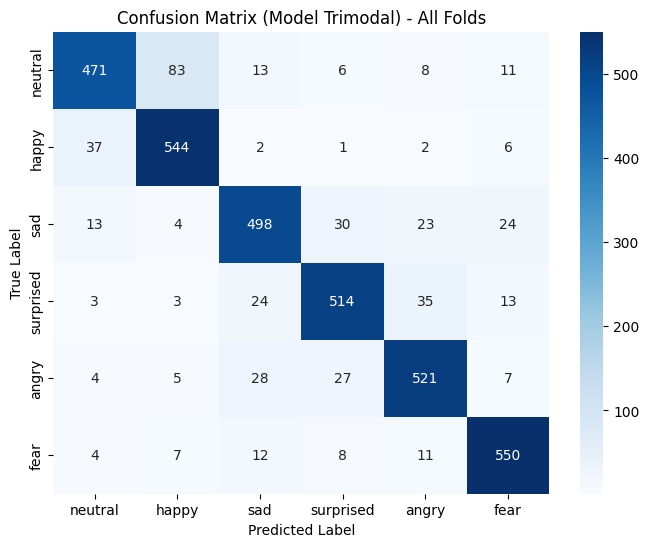


Best Fold untuk Model Trimodal: Fold 8 dengan Accuracy 0.94


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, MultiHeadAttention, Add, LayerNormalization, GlobalAveragePooling1D, Concatenate
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# MODEL UNTUK PERBANDINGAN

# 1. Model Unimodal
def build_unimodal_text_model(input_dim, num_classes):
    """Classification model with text modality."""
    text_input = Input(shape=(input_dim,), name='text_input')
    dense1 = Dense(256, activation='relu')(text_input)
    dense2 = Dense(128, activation='relu')(dense1)
    output = Dense(num_classes, activation='softmax')(dense2)
    model = Model(inputs=text_input, outputs=output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def build_bimodal_late_fusion_model(input_dims, num_classes):
    """Classification model with text and audio modalities using Late Fusion."""
    text_input = Input(shape=(input_dims[0],), name='text_input')
    audio_input = Input(shape=(input_dims[1],), name='audio_input')

    # Proyeksi setiap modalitas
    text_proj = Dense(128, activation='relu')(text_input)
    audio_proj = Dense(128, activation='relu')(audio_input)

    # Penggabungan Late Fusion
    merged = Concatenate()([text_proj, audio_proj])

    # Classifier
    classifier = Dense(128, activation='relu')(merged)
    output = Dense(num_classes, activation='softmax')(classifier)

    model = Model(inputs=[text_input, audio_input], outputs=output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def build_trimodal_late_fusion_model(input_dims, num_classes):
    """Classification model with text, audio, and image modalities using Late Fusion."""
    text_input = Input(shape=(input_dims[0],), name='text_input')
    audio_input = Input(shape=(input_dims[1],), name='audio_input')
    image_input = Input(shape=(input_dims[2],), name='image_input')

    # Proyeksi setiap modalitas
    text_proj = Dense(128, activation='relu')(text_input)
    audio_proj = Dense(128, activation='relu')(audio_input)
    image_proj = Dense(128, activation='relu')(image_input)

    # Penggabungan Late Fusion
    merged = Concatenate()([text_proj, audio_proj, image_proj])

    # Classifier
    classifier_1 = Dense(256, activation='relu')(merged)
    classifier_2 = Dense(128, activation='relu')(classifier_1)
    output = Dense(num_classes, activation='softmax')(classifier_2)

    model = Model(inputs=[text_input, audio_input, image_input], outputs=output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# ==============================================================================
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

results = {
    "1. Text-Only": { "accuracy_scores": [], "f1_scores": [], "y_true_per_fold": [], "y_pred_per_fold": [] },
    "2. Text + Audio (Late Fusion)": { "accuracy_scores": [], "f1_scores": [], "y_true_per_fold": [], "y_pred_per_fold": [] },
    "3. Text + Audio + Image (Late Fusion)": { "accuracy_scores": [], "f1_scores": [], "y_true_per_fold": [], "y_pred_per_fold": [] },
}

best_fold_trimodal = {"index": -1, "accuracy": 0.0}

# LOOP PELATIHAN DAN EVALUASI UNTUK PERBANDINGAN
for fold, (train_idx, test_idx) in enumerate(kf.split(X_text_resampled, y_resampled)):
    print(f"\n{'='*20} FOLD {fold+1}/{kf.get_n_splits()} {'='*20}")

    X_train_text, X_test_text = X_text_resampled[train_idx], X_text_resampled[test_idx]
    X_train_audio, X_test_audio = X_audio_resampled[train_idx], X_audio_resampled[test_idx]
    X_train_image, X_test_image = X_image_resampled[train_idx], X_image_resampled[test_idx]
    y_train, y_test = y_resampled[train_idx], y_resampled[test_idx]
    num_classes = len(COMMON_LABELS)

    models_to_train = {
        "1. Text-Only": build_unimodal_text_model(X_train_text.shape[1], num_classes),
        "2. Text + Audio (Late Fusion)": build_bimodal_late_fusion_model([X_train_text.shape[1], X_train_audio.shape[1]], num_classes),
        "3. Text + Audio + Image (Late Fusion)": build_trimodal_late_fusion_model([X_train_text.shape[1], X_train_audio.shape[1], X_train_image.shape[1]], num_classes)
    }

    for name, model in models_to_train.items():
        print(f"\n--- Training model: {name} ---")

        if name == "1. Text-Only":
            train_input = X_train_text
            test_input = X_test_text
        elif name.startswith("2. Text + Audio"):
            train_input = {'text_input': X_train_text, 'audio_input': X_train_audio}
            test_input = {'text_input': X_test_text, 'audio_input': X_test_audio}
        else: # Trimodal
            train_input = {'text_input': X_train_text, 'audio_input': X_train_audio, 'image_input': X_train_image}
            test_input = {'text_input': X_test_text, 'audio_input': X_test_audio, 'image_input': X_test_image}

        verbose_level = 1 if name.startswith("3. Text + Audio + Image") else 0

        model.fit(train_input, y_train, batch_size=32, epochs=15, verbose=verbose_level)
        y_pred_probs = model.predict(test_input)
        y_pred = np.argmax(y_pred_probs, axis=1)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')

        results[name]["accuracy_scores"].append(acc)
        results[name]["f1_scores"].append(f1)
        results[name]["y_true_per_fold"].append(y_test)
        results[name]["y_pred_per_fold"].append(y_pred)

        print(f"  > Fold {fold+1} Result for {name}: Accuracy = {acc:.4f}, F1-Score = {f1:.4f}")

        if name.startswith("3. Text + Audio + Image"):
            if acc > best_fold_trimodal["accuracy"]:
                best_fold_trimodal["index"] = fold + 1
                best_fold_trimodal["accuracy"] = acc
                model.save(f"/content/drive/MyDrive/MODEL/best_trimodal_late_fusion_model_fold_{fold+1}.keras")
                print(f"  > Best Trimodal model saved from fold {fold+1}")

print("\nTraining and evaluation complete. The 'results' dictionary now contains all data.")

print(f"\n{'='*25} FINAL MODEL COMPARISON RESULTS {'='*25}")
summary_data = []
for name, metrics in results.items():
    mean_acc = np.mean(metrics['accuracy_scores'])
    std_acc = np.std(metrics['accuracy_scores'])
    mean_f1 = np.mean(metrics['f1_scores'])
    std_f1 = np.std(metrics['f1_scores'])
    summary_data.append({
        "Model": name,
        "Mean Accuracy": f"{mean_acc:.4f} ± {std_acc:.4f}",
        "Mean F1-Score": f"{mean_f1:.4f} ± {std_f1:.4f}"
    })
summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

print(f"\n{'='*25} DETAIL EVALUASI MODEL UTAMA (Trimodal) {'='*25}")

# Classification Report model utama di semua fold
print("\nClassification Report (Model Trimodal - Across All Folds):\n")
print(classification_report(y_true_all_trimodal, y_pred_all_trimodal, target_names=COMMON_LABELS))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_all_trimodal, y_pred_all_trimodal)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=COMMON_LABELS, yticklabels=COMMON_LABELS)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Model Trimodal) - All Folds")
plt.show()

print(f"\nBest Fold untuk Model Trimodal: Fold {best_fold_trimodal['index']} dengan Accuracy {best_fold_trimodal['accuracy']:.2f}")

# **EARLY FUSION**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# MODEL UNTUK PERBANDINGAN

# 1. Model Unimodal
def build_unimodal_text_model(input_dim, num_classes):
    """Classification model with text modality."""
    text_input = Input(shape=(input_dim,), name='text_input')
    dense1 = Dense(256, activation='relu')(text_input)
    dense2 = Dense(128, activation='relu')(dense1)
    output = Dense(num_classes, activation='softmax')(dense2)
    model = Model(inputs=text_input, outputs=output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Model Bimodal
def build_bimodal_early_fusion_model(input_dims, num_classes):
    """Classification model with text and audio modalities using Early Fusion."""
    text_input = Input(shape=(input_dims[0],), name='text_input')
    audio_input = Input(shape=(input_dims[1],), name='audio_input')

    # Penggabungan Early Fusion
    merged = Concatenate()([text_input, audio_input])

    # Classifier (MLP)
    classifier_1 = Dense(256, activation='relu')(merged)
    classifier_2 = Dense(128, activation='relu')(classifier_1)
    output = Dense(num_classes, activation='softmax')(classifier_2)

    model = Model(inputs=[text_input, audio_input], outputs=output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Model Trimodal
def build_trimodal_early_fusion_model(input_dims, num_classes):
    """Classification model with text, audio, and image modalities using Early Fusion."""
    text_input = Input(shape=(input_dims[0],), name='text_input')
    audio_input = Input(shape=(input_dims[1],), name='audio_input')
    image_input = Input(shape=(input_dims[2],), name='image_input')

    # Penggabungan Early Fusion
    merged = Concatenate()([text_input, audio_input, image_input])

    # Classifier (MLP)
    classifier_1 = Dense(512, activation='relu')(merged)
    classifier_2 = Dense(256, activation='relu')(classifier_1)
    classifier_3 = Dense(128, activation='relu')(classifier_2)
    output = Dense(num_classes, activation='softmax')(classifier_3)

    model = Model(inputs=[text_input, audio_input, image_input], outputs=output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

results = {
    "1. Text-Only": { "accuracy_scores": [], "f1_scores": [], "y_true_per_fold": [], "y_pred_per_fold": [] },
    "2. Text + Audio (Early Fusion)": { "accuracy_scores": [], "f1_scores": [], "y_true_per_fold": [], "y_pred_per_fold": [] },
    "3. Text + Audio + Image (Early Fusion)": { "accuracy_scores": [], "f1_scores": [], "y_true_per_fold": [], "y_pred_per_fold": [] },
}

best_fold_trimodal = {"index": -1, "accuracy": 0.0}

# ==============================================================================
for fold, (train_idx, test_idx) in enumerate(kf.split(X_text_resampled, y_resampled)):
    print(f"\n{'='*20} FOLD {fold+1}/{kf.get_n_splits()} {'='*20}")

    X_train_text, X_test_text = X_text_resampled[train_idx], X_text_resampled[test_idx]
    X_train_audio, X_test_audio = X_audio_resampled[train_idx], X_audio_resampled[test_idx]
    X_train_image, X_test_image = X_image_resampled[train_idx], X_image_resampled[test_idx]
    y_train, y_test = y_resampled[train_idx], y_resampled[test_idx]
    num_classes = len(COMMON_LABELS)

    models_to_train = {
        "1. Text-Only": build_unimodal_text_model(X_train_text.shape[1], num_classes),
        "2. Text + Audio (Early Fusion)": build_bimodal_early_fusion_model([X_train_text.shape[1], X_train_audio.shape[1]], num_classes),
        "3. Text + Audio + Image (Early Fusion)": build_trimodal_early_fusion_model([X_train_text.shape[1], X_train_audio.shape[1], X_train_image.shape[1]], num_classes)
    }

    for name, model in models_to_train.items():
        print(f"\n--- Training model: {name} ---")

        if name == "1. Text-Only":
            train_input = X_train_text
            test_input = X_test_text
        elif name.startswith("2. Text + Audio"):
            train_input = {'text_input': X_train_text, 'audio_input': X_train_audio}
            test_input = {'text_input': X_test_text, 'audio_input': X_test_audio}
        else: # Trimodal
            train_input = {'text_input': X_train_text, 'audio_input': X_train_audio, 'image_input': X_train_image}
            test_input = {'text_input': X_test_text, 'audio_input': X_test_audio, 'image_input': X_test_image}

        verbose_level = 1 if name.startswith("3. Text + Audio + Image") else 0

        model.fit(train_input, y_train, batch_size=32, epochs=15, verbose=verbose_level)
        y_pred_probs = model.predict(test_input)
        y_pred = np.argmax(y_pred_probs, axis=1)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')

        results[name]["accuracy_scores"].append(acc)
        results[name]["f1_scores"].append(f1)
        results[name]["y_true_per_fold"].append(y_test)
        results[name]["y_pred_per_fold"].append(y_pred)

        print(f"  > Fold {fold+1} Result for {name}: Accuracy = {acc:.4f}, F1-Score = {f1:.4f}")

        if name.startswith("3. Text + Audio + Image"):
            if acc > best_fold_trimodal["accuracy"]:
                best_fold_trimodal["index"] = fold + 1
                best_fold_trimodal["accuracy"] = acc
                model.save(f"/content/drive/MyDrive/MODEL/best_trimodal_early_fusion_model_fold_{fold+1}.keras")
                print(f"  > Best Trimodal model saved from fold {fold+1}")


==================== FOLD 1/10 ====================

--- Training model: 1. Text-Only ---
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
  > Fold 1 Result for 1. Text-Only: Accuracy = 0.6545, F1-Score = 0.6539

--- Training model: 2. Text + Audio (Early Fusion) ---
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
  > Fold 1 Result for 2. Text + Audio (Early Fusion): Accuracy = 0.7669, F1-Score = 0.7593

--- Training model: 3. Text + Audio + Image (Early Fusion) ---
Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6075 - loss: 0.9930
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9064 - loss: 0.2783
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9553 - loss: 0.1368
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9791 - loss: 0.0719
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9881 - loss: 0.0386
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9981 - loss: 0.0114
Epoch 7/15
100/100 ━━━━━━━━━

# **TRANSFORMER-BASED FUSION**


==================== FOLD 1/10 ====================

--- Training model: 1. Text-Only ---
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
  > Fold 1 Result for 1. Text-Only: Accuracy = 0.6433, F1-Score = 0.6416

--- Training model: 2. Text + Audio ---
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step
  > Fold 1 Result for 2. Text + Audio: Accuracy = 0.8006, F1-Score = 0.7940

--- Training model: 3. Text + Audio + Image ---
Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.5465 - loss: 1.1419
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8849 - loss: 0.3314
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9484 - loss: 0.1557
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9739 - loss: 0.0806
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9939 - loss: 0.0351
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9932 - loss: 0.0285
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9961 - 

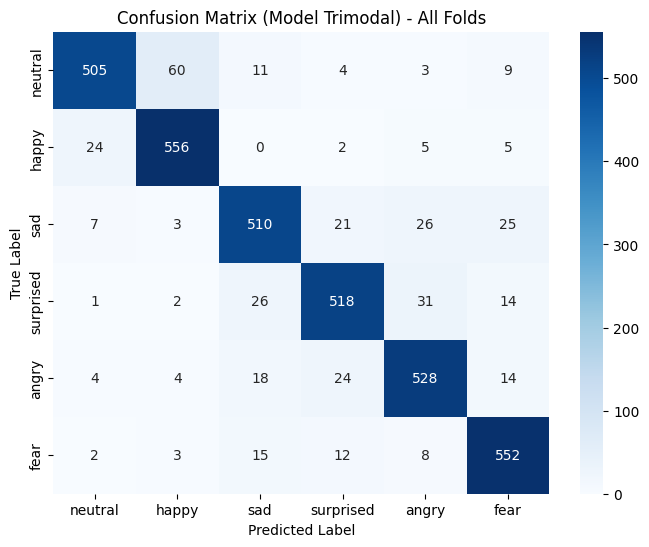


Best Fold untuk Model Trimodal: Fold 9 dengan Accuracy 0.95


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, MultiHeadAttention, Add, LayerNormalization, GlobalAveragePooling1D
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# MODEL UNTUK PERBANDINGAN

# 1. Model Unimodal
def build_unimodal_text_model(input_dim, num_classes):
    """Classification model with text modality."""
    text_input = Input(shape=(input_dim,), name='text_input')

    # Arsitektur MLP
    dense1 = Dense(256, activation='relu')(text_input)
    dense2 = Dense(128, activation='relu')(dense1)
    output = Dense(num_classes, activation='softmax')(dense2)

    model = Model(inputs=text_input, outputs=output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# 2. Model Bimodal
def build_bimodal_text_audio_model(input_dims, num_classes):
    """Classification model with text and audio modalities."""
    text_input = Input(shape=(input_dims[0],), name='text_input')
    audio_input = Input(shape=(input_dims[1],), name='audio_input')

    text_proj = Dense(128, activation='relu')(text_input)
    audio_proj = Dense(128, activation='relu')(audio_input)

    # Stack untuk membentuk sekuens (N, 2, 128)
    merged = Lambda(lambda x: tf.stack(x, axis=1))([text_proj, audio_proj])

    # Transformer Encoder Block
    attn_output = MultiHeadAttention(num_heads=4, key_dim=64)(merged, merged)
    attn_output = Add()([merged, attn_output])
    attn_output = LayerNormalization()(attn_output)

    ffn = Dense(128, activation='relu')(attn_output)
    ffn_output = Add()([attn_output, ffn])
    ffn_output = LayerNormalization()(ffn_output)

    pooled = GlobalAveragePooling1D()(ffn_output)
    output = Dense(num_classes, activation='softmax')(pooled)

    model = Model(inputs=[text_input, audio_input], outputs=output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# 3. Model Trimodal (Teks + Audio + Gambar)
def build_trimodal_transformer_model(input_dims, num_classes):
    """Classification model with text, audio, and image modalities."""
    text_input = tf.keras.layers.Input(shape=(input_dims[0],), name='text_input')
    audio_input = tf.keras.layers.Input(shape=(input_dims[1],), name='audio_input')
    image_input = tf.keras.layers.Input(shape=(input_dims[2],), name='image_input')

    text_proj = tf.keras.layers.Dense(128, activation='relu')(text_input)
    audio_proj = tf.keras.layers.Dense(128, activation='relu')(audio_input)
    image_proj = tf.keras.layers.Dense(128, activation='relu')(image_input)

    merged = tf.keras.layers.Lambda(lambda x: tf.stack(x, axis=1))([text_proj, audio_proj, image_proj])

    attn_output = tf.keras.layers.MultiHeadAttention(num_heads=4, key_dim=64)(merged, merged)
    attn_output = tf.keras.layers.Add()([merged, attn_output])
    attn_output = tf.keras.layers.LayerNormalization()(attn_output)

    ffn = tf.keras.layers.Dense(128, activation='relu')(attn_output)
    ffn = tf.keras.layers.Dense(128, activation='relu')(ffn)
    ffn_output = tf.keras.layers.Add()([attn_output, ffn])
    ffn_output = tf.keras.layers.LayerNormalization()(ffn_output)

    pooled = tf.keras.layers.GlobalAveragePooling1D()(ffn_output)
    output = tf.keras.layers.Dense(num_classes, activation='softmax')(pooled)

    model = tf.keras.Model(inputs=[text_input, audio_input, image_input], outputs=output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# ==============================================================================
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Penyimpan semua data
results = {
    "1. Text-Only": {
        "accuracy_scores": [], "f1_scores": [],
        "y_true_per_fold": [], "y_pred_per_fold": []
    },
    "2. Text + Audio": {
        "accuracy_scores": [], "f1_scores": [],
        "y_true_per_fold": [], "y_pred_per_fold": []
    },
    "3. Text + Audio + Image": {
        "accuracy_scores": [], "f1_scores": [],
        "y_true_per_fold": [], "y_pred_per_fold": []
    },
}

best_fold_trimodal = {"index": -1, "accuracy": 0.0}

# ==============================================================================
for fold, (train_idx, test_idx) in enumerate(kf.split(X_text_resampled, y_resampled)):
    print(f"\n{'='*20} FOLD {fold+1}/{kf.get_n_splits()} {'='*20}")

    X_train_text, X_test_text = X_text_resampled[train_idx], X_text_resampled[test_idx]
    X_train_audio, X_test_audio = X_audio_resampled[train_idx], X_audio_resampled[test_idx]
    X_train_image, X_test_image = X_image_resampled[train_idx], X_image_resampled[test_idx]
    y_train, y_test = y_resampled[train_idx], y_resampled[test_idx]

    num_classes = len(COMMON_LABELS)

    models_to_train = {
        "1. Text-Only": build_unimodal_text_model(X_train_text.shape[1], num_classes),
        "2. Text + Audio": build_bimodal_text_audio_model([X_train_text.shape[1], X_train_audio.shape[1]], num_classes),
        "3. Text + Audio + Image": build_trimodal_transformer_model([X_train_text.shape[1], X_train_audio.shape[1], X_train_image.shape[1]], num_classes)
    }

    # Pelatihan dan evaluasi setiap model
    for name, model in models_to_train.items():
        print(f"\n--- Training model: {name} ---")

        if name == "1. Text-Only":
            train_input = X_train_text
            test_input = X_test_text
        elif name == "2. Text + Audio":
            train_input = {'text_input': X_train_text, 'audio_input': X_train_audio}
            test_input = {'text_input': X_test_text, 'audio_input': X_test_audio}
        else: # "3. Text + Audio + Image"
            train_input = {'text_input': X_train_text, 'audio_input': X_train_audio, 'image_input': X_train_image}
            test_input = {'text_input': X_test_text, 'audio_input': X_test_audio, 'image_input': X_test_image}

        verbose_level = 1 if name == "3. Text + Audio + Image" else 0

        model.fit(train_input, y_train, batch_size=32, epochs=15, verbose=verbose_level)
        y_pred_probs = model.predict(test_input)
        y_pred = np.argmax(y_pred_probs, axis=1)

        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')

        results[name]["accuracy_scores"].append(acc)
        results[name]["f1_scores"].append(f1)
        results[name]["y_true_per_fold"].append(y_test)
        results[name]["y_pred_per_fold"].append(y_pred)

        print(f"  > Fold {fold+1} Result for {name}: Accuracy = {acc:.4f}, F1-Score = {f1:.4f}")

        if name == "3. Text + Audio + Image":
            if acc > best_fold_trimodal["accuracy"]:
                best_fold_trimodal["index"] = fold + 1
                best_fold_trimodal["accuracy"] = acc
                model.save(f"/content/drive/MyDrive/MODEL/best_trimodal_model_fold_{fold+1}.keras")
                print(f"  > Best Trimodal model saved from fold {fold+1}")


# ==============================================================================
print("\nTraining and evaluation complete. The 'results' dictionary now contains all data.")

# tabel ringkasan
print(f"\n{'='*25} FINAL MODEL COMPARISON RESULTS {'='*25}")
summary_data = []
for name, metrics in results.items():
    mean_acc = np.mean(metrics['accuracy_scores'])
    std_acc = np.std(metrics['accuracy_scores'])
    mean_f1 = np.mean(metrics['f1_scores'])
    std_f1 = np.std(metrics['f1_scores'])
    summary_data.append({
        "Model": name,
        "Mean Accuracy": f"{mean_acc:.4f} ± {std_acc:.4f}",
        "Mean F1-Score": f"{mean_f1:.4f} ± {std_f1:.4f}"
    })
summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

print(f"\n{'='*25} DETAIL EVALUASI MODEL UTAMA (Trimodal) {'='*25}")

# Classification Report model utama di semua fold
print("\nClassification Report (Model Trimodal - Across All Folds):\n")
print(classification_report(y_true_all_trimodal, y_pred_all_trimodal, target_names=COMMON_LABELS))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_all_trimodal, y_pred_all_trimodal)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=COMMON_LABELS, yticklabels=COMMON_LABELS)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Model Trimodal) - All Folds")
plt.show()

print(f"\nBest Fold untuk Model Trimodal: Fold {best_fold_trimodal['index']} dengan Accuracy {best_fold_trimodal['accuracy']:.2f}")

Kode diatas juga menggunakan Stratified K-Fold Cross Validation agar split datanya tidak hanya dibagi pada data yang statis, tetapi mencoba kombinasi menggunakan 10 fold (90 : 10) dimana setiap foldnya melakukan kombinasi 90% : 10% pemilihan data train dan data test nya secara bergantian. Artinya, cara ini lebih stabil dan adil, serta tidak bergantung pada keberuntungan pemisahan data. Dapat dilihat bahwa dengan kombinasi ini, pada Fold ke 9 mampu menghasilkan akurasi sebesar **0.9465 atau 95%**

/tmp/ipython-input-31-525261034.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(model_comparison_scores.keys()), y=list(model_comparison_scores.values()), ax=ax1, palette="viridis")


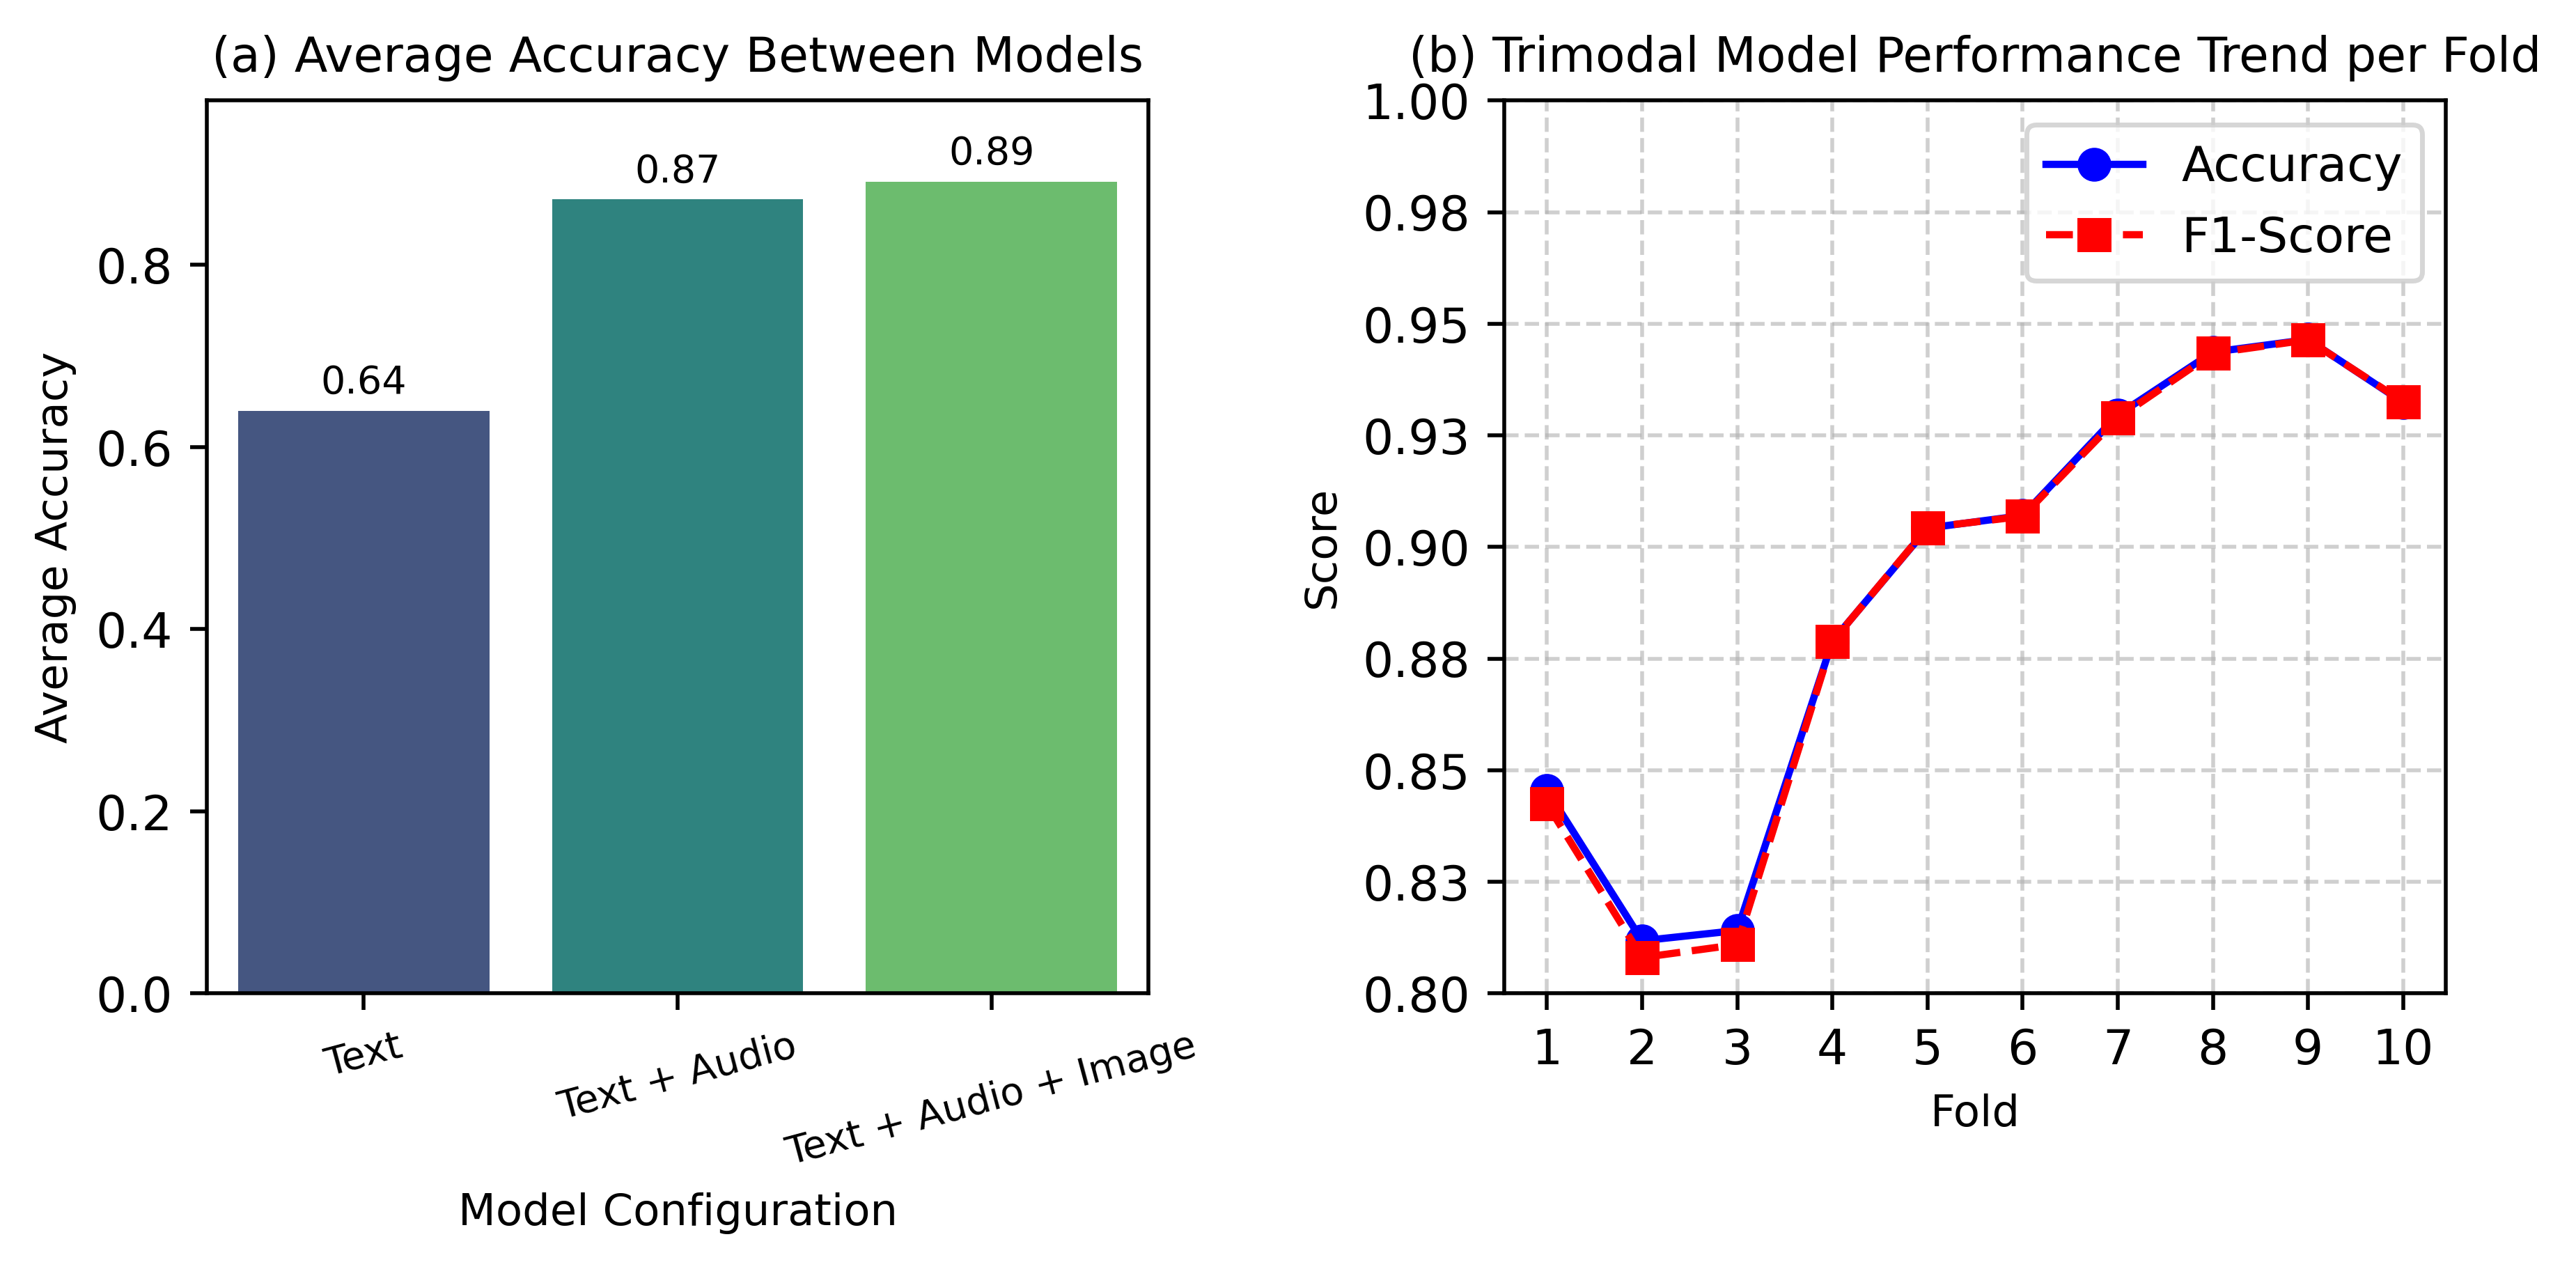

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.ticker as mticker

dpi = 500
total_pixel_width = 3740
height_inch = 4
total_width_inch = total_pixel_width / dpi
figsize_combined = (total_width_inch, height_inch)

# Data Extraction
model_comparison_scores = {
    "Text": np.mean(results["1. Text-Only"]["accuracy_scores"]),
    "Text + Audio": np.mean(results["2. Text + Audio"]["accuracy_scores"]),
    "Text + Audio + Image": np.mean(results["3. Text + Audio + Image"]["accuracy_scores"])
}
trimodal_accuracy_scores = results["3. Text + Audio + Image"]["accuracy_scores"]
trimodal_f1_scores = results["3. Text + Audio + Image"]["f1_scores"]
folds = list(range(1, len(trimodal_accuracy_scores) + 1))

fig, axes = plt.subplots(1, 2, figsize=figsize_combined, dpi=dpi)

# Subplot 1: Bar Chart of Model Accuracy Comparison
ax1 = axes[0]
sns.barplot(x=list(model_comparison_scores.keys()), y=list(model_comparison_scores.values()), ax=ax1, palette="viridis")
ax1.set_title("(a) Average Accuracy Between Models", fontsize=10)
ax1.set_xlabel("Model Configuration", fontsize=9)
ax1.set_ylabel("Average Accuracy", fontsize=9)
ax1.tick_params(axis='x', rotation=15, labelsize=8)
ax1.set_ylim(0, max(model_comparison_scores.values()) * 1.1)
for index, value in enumerate(model_comparison_scores.values()):
    ax1.text(index, value + 0.01, f"{value:.2f}", ha="center", va="bottom", fontsize=8)

# Subplot 2: Performance Trend of the Main (Trimodal) Model
ax2 = axes[1]
ax2.plot(folds, trimodal_accuracy_scores, marker='o', linestyle='-', label="Accuracy", color="blue")
ax2.plot(folds, trimodal_f1_scores, marker='s', linestyle='--', label="F1-Score", color="red")
ax2.set_xticks(folds)
ax2.set_xlabel("Fold", fontsize=9)
ax2.set_ylabel("Score", fontsize=9)
ax2.set_title("(b) Trimodal Model Performance Trend per Fold", fontsize=10)
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.set_ylim(0.8, 1)

formatter = mticker.FormatStrFormatter('%.2f')
ax2.yaxis.set_major_formatter(formatter)

plt.tight_layout(pad=2.0)
plt.savefig(f"model_comparison_and_trend_{dpi}dpi_en.png", dpi=dpi, bbox_inches='tight')
plt.show()

# **TRANSFORMER-BASED FUSION**


DISPLAYING PEAK PERFORMANCE REPORT FOR EACH MODEL
(Each report is from the best fold for that specific model)

--- Model: 1. Text-Only ---
Peak Performance at Fold: 10 with Accuracy: 0.6761

              precision    recall  f1-score   support

     neutral       0.76      0.75      0.75        59
       happy       0.79      0.82      0.80        60
         sad       0.55      0.61      0.58        59
   surprised       0.49      0.47      0.48        59
       angry       0.76      0.71      0.74        59
        fear       0.71      0.69      0.70        59

    accuracy                           0.68       355
   macro avg       0.68      0.68      0.68       355
weighted avg       0.68      0.68      0.68       355


##################################################

--- Model: 2. Text + Audio ---
Peak Performance at Fold: 9 with Accuracy: 0.9296

              precision    recall  f1-score   support

     neutral       0.97      1.00      0.98        59
       happy       1.

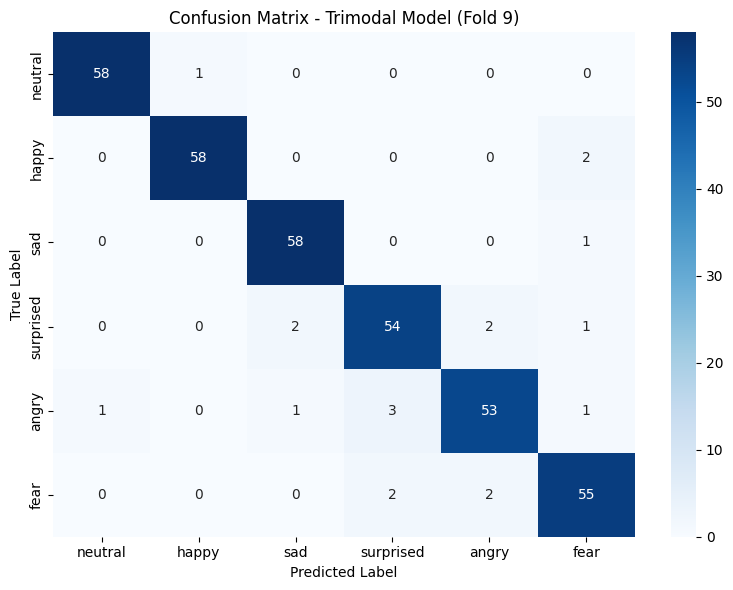

[✔] Gambar confusion matrix disimpan: conf_matrix_trimodal_fold9_300dpi.png


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# 1. LAPORAN PERFORMA PUNCAK UNTUK SETIAP MODEL

print(f"\n{'='*25}")
print("DISPLAYING PEAK PERFORMANCE REPORT FOR EACH MODEL")
print("(Each report is from the best fold for that specific model)")
print(f"{'='*25}\n")

for model_name, data in results.items():
    accuracy_scores = data["accuracy_scores"]
    best_fold_idx = np.argmax(accuracy_scores)
    max_accuracy = accuracy_scores[best_fold_idx]

    y_true_peak = data["y_true_per_fold"][best_fold_idx]
    y_pred_peak = data["y_pred_per_fold"][best_fold_idx]

    print(f"--- Model: {model_name} ---")
    print(f"Peak Performance at Fold: {best_fold_idx + 1} with Accuracy: {max_accuracy:.4f}\n")

    print(classification_report(y_true_peak, y_pred_peak, target_names=COMMON_LABELS))
    print("\n" + "#"*50 + "\n")


# 2. CONFUSION MATRIX UNTUK MODEL TRIMODAL DARI FOLD 9

print("\n--- Confusion Matrix for Trimodal Model (Fold 9) ---")

dpi = 300
pixel_width_conf = 2400
figsize_conf = (pixel_width_conf / dpi, (pixel_width_conf / dpi) * 0.75)

try:
    fold_9_index = 8
    y_true_trimodal_fold9 = results["3. Text + Audio + Image"]["y_true_per_fold"][fold_9_index]
    y_pred_trimodal_fold9 = results["3. Text + Audio + Image"]["y_pred_per_fold"][fold_9_index]

    # confusion matrix
    conf_matrix = confusion_matrix(y_true_trimodal_fold9, y_pred_trimodal_fold9)

    # Plotting
    plt.figure(figsize=figsize_conf)
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=COMMON_LABELS, yticklabels=COMMON_LABELS)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix - Trimodal Model (Fold 9)")
    plt.tight_layout()

    # Simpan dan tampilkan
    save_path = f"conf_matrix_trimodal_fold9_{dpi}dpi.png"
    plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
    plt.show()
    print(f"[✔] Gambar confusion matrix disimpan: {save_path}")

except IndexError:
    print(f"[!] Error: Tidak dapat mengakses data untuk Fold 9. Pastikan cross-validation berjalan setidaknya 9 folds.")

# **LATE FUSION**


DISPLAYING PEAK PERFORMANCE REPORT FOR EACH MODEL
(Each report is from the best fold for that specific model)

--- Model: 1. Text-Only ---
Peak Performance at Fold: 4 with Accuracy: 0.6648

              precision    recall  f1-score   support

     neutral       0.69      0.63      0.65        59
       happy       0.78      0.83      0.80        59
         sad       0.60      0.62      0.61        60
   surprised       0.61      0.51      0.56        59
       angry       0.59      0.61      0.60        59
        fear       0.71      0.80      0.75        59

    accuracy                           0.66       355
   macro avg       0.66      0.66      0.66       355
weighted avg       0.66      0.66      0.66       355


##################################################

--- Model: 2. Text + Audio (Late Fusion) ---
Peak Performance at Fold: 9 with Accuracy: 0.9352

              precision    recall  f1-score   support

     neutral       0.98      1.00      0.99        59
       h

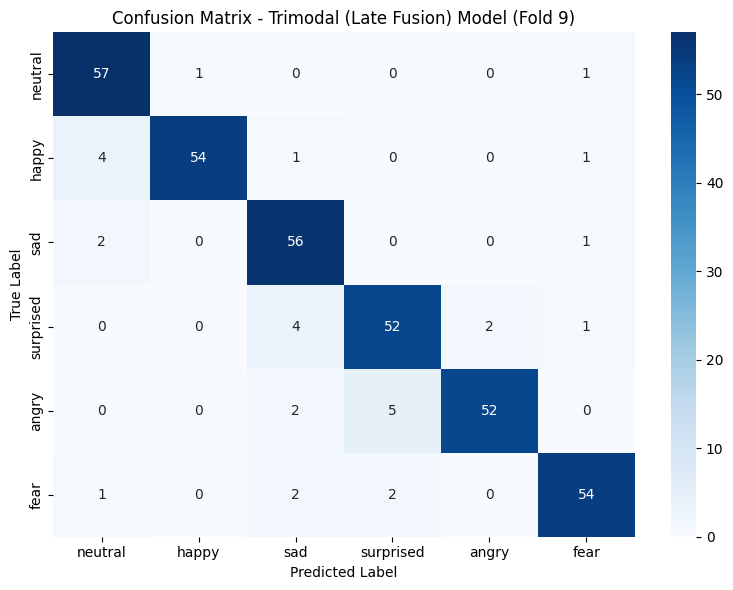

[✔] Gambar confusion matrix disimpan: conf_matrix_trimodal_late_fusion_fold9_300dpi.png


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# 1. LAPORAN PERFORMA PUNCAK UNTUK SETIAP MODEL

print(f"\n{'='*25}")
print("DISPLAYING PEAK PERFORMANCE REPORT FOR EACH MODEL")
print("(Each report is from the best fold for that specific model)")
print(f"{'='*25}\n")

for model_name, data in results.items():
    accuracy_scores = data["accuracy_scores"]
    best_fold_idx = np.argmax(accuracy_scores)
    max_accuracy = accuracy_scores[best_fold_idx]

    y_true_peak = data["y_true_per_fold"][best_fold_idx]
    y_pred_peak = data["y_pred_per_fold"][best_fold_idx]

    print(f"--- Model: {model_name} ---")
    print(f"Peak Performance at Fold: {best_fold_idx + 1} with Accuracy: {max_accuracy:.4f}\n")

    print(classification_report(y_true_peak, y_pred_peak, target_names=COMMON_LABELS))
    print("\n" + "#"*50 + "\n")


# 2. CONFUSION MATRIX UNTUK MODEL TRIMODAL DARI FOLD 9

print("\n--- Confusion Matrix for Trimodal (Late Fusion) Model (Fold 9) ---")

dpi = 300
pixel_width_conf = 2400
figsize_conf = (pixel_width_conf / dpi, (pixel_width_conf / dpi) * 0.75)

trimodal_key = "3. Text + Audio + Image (Late Fusion)"

try:
    fold_9_index = 8
    y_true_trimodal_fold9 = results[trimodal_key]["y_true_per_fold"][fold_9_index]
    y_pred_trimodal_fold9 = results[trimodal_key]["y_pred_per_fold"][fold_9_index]

    conf_matrix = confusion_matrix(y_true_trimodal_fold9, y_pred_trimodal_fold9)

    plt.figure(figsize=figsize_conf)
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=COMMON_LABELS, yticklabels=COMMON_LABELS)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix - Trimodal (Late Fusion) Model (Fold 9)")
    plt.tight_layout()

    save_path = f"conf_matrix_trimodal_late_fusion_fold9_{dpi}dpi.png"
    plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
    plt.show()
    print(f"[✔] Gambar confusion matrix disimpan: {save_path}")

except KeyError:
    print(f"[!] Error: Kunci model '{trimodal_key}' tidak ditemukan di dictionary 'results'.")
except IndexError:
    print(f"[!] Error: Tidak dapat mengakses data untuk Fold 9. Pastikan cross-validation berjalan setidaknya 9 folds.")

# **EARLY FUSION**


DISPLAYING PEAK PERFORMANCE REPORT FOR EACH MODEL
(Each report is from the best fold for that specific model)

--- Model: 1. Text-Only ---
Peak Performance at Fold: 7 with Accuracy: 0.6732

              precision    recall  f1-score   support

     neutral       0.82      0.54      0.65        59
       happy       0.74      0.93      0.83        59
         sad       0.60      0.53      0.56        59
   surprised       0.53      0.61      0.57        59
       angry       0.71      0.83      0.77        60
        fear       0.67      0.59      0.63        59

    accuracy                           0.67       355
   macro avg       0.68      0.67      0.67       355
weighted avg       0.68      0.67      0.67       355


##################################################

--- Model: 2. Text + Audio (Early Fusion) ---
Peak Performance at Fold: 10 with Accuracy: 0.9211

              precision    recall  f1-score   support

     neutral       0.92      0.95      0.93        59
      

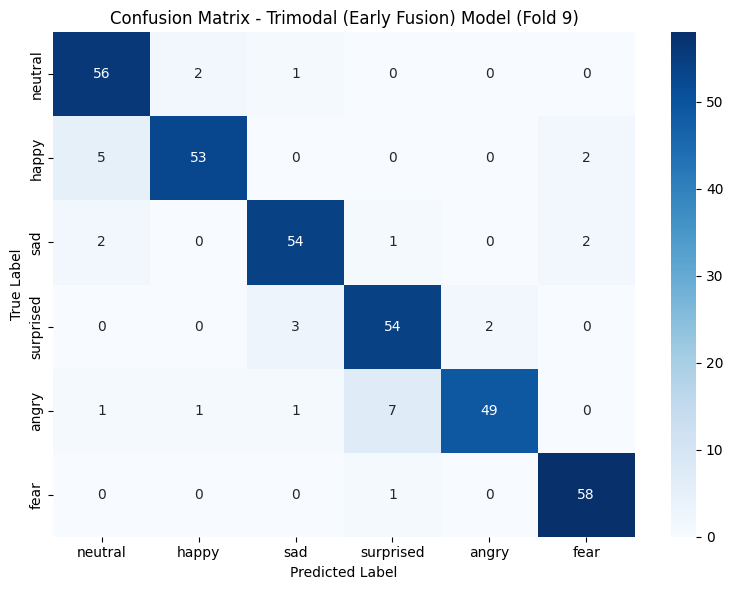

[✔] Gambar confusion matrix disimpan: conf_matrix_trimodal_early_fusion_fold9_300dpi.png


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# 1. LAPORAN PERFORMA PUNCAK UNTUK SETIAP MODEL

print(f"\n{'='*25}")
print("DISPLAYING PEAK PERFORMANCE REPORT FOR EACH MODEL")
print("(Each report is from the best fold for that specific model)")
print(f"{'='*25}\n")

for model_name, data in results.items():
    accuracy_scores = data["accuracy_scores"]
    best_fold_idx = np.argmax(accuracy_scores)
    max_accuracy = accuracy_scores[best_fold_idx]

    y_true_peak = data["y_true_per_fold"][best_fold_idx]
    y_pred_peak = data["y_pred_per_fold"][best_fold_idx]

    print(f"--- Model: {model_name} ---")
    print(f"Peak Performance at Fold: {best_fold_idx + 1} with Accuracy: {max_accuracy:.4f}\n")

    print(classification_report(y_true_peak, y_pred_peak, target_names=COMMON_LABELS))
    print("\n" + "#"*50 + "\n")


# 2. CONFUSION MATRIX UNTUK MODEL TRIMODAL DARI FOLD 9

print("\n--- Confusion Matrix for Trimodal (Early Fusion) Model (Fold 9) ---")

dpi = 300
pixel_width_conf = 2400
figsize_conf = (pixel_width_conf / dpi, (pixel_width_conf / dpi) * 0.75)

trimodal_key = "3. Text + Audio + Image (Early Fusion)"

try:
    fold_9_index = 8
    y_true_trimodal_fold9 = results[trimodal_key]["y_true_per_fold"][fold_9_index]
    y_pred_trimodal_fold9 = results[trimodal_key]["y_pred_per_fold"][fold_9_index]

    conf_matrix = confusion_matrix(y_true_trimodal_fold9, y_pred_trimodal_fold9)

    plt.figure(figsize=figsize_conf)
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=COMMON_LABELS, yticklabels=COMMON_LABELS)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix - Trimodal (Early Fusion) Model (Fold 9)")
    plt.tight_layout()

    save_path = f"conf_matrix_trimodal_early_fusion_fold9_{dpi}dpi.png"
    plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
    plt.show()
    print(f"[✔] Gambar confusion matrix disimpan: {save_path}")

except KeyError:
    print(f"[!] Error: Kunci model '{trimodal_key}' tidak ditemukan di dictionary 'results'.")
except IndexError:
    print(f"[!] Error: Tidak dapat mengakses data untuk Fold 9. Pastikan cross-validation berjalan setidaknya 9 folds.")